## Classification

In [9]:
import os

path_to_data = "./images_dataset/cropped/"
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['./images_dataset/cropped/David_Schwimmer',
 './images_dataset/cropped/Jennifer_Aniston',
 './images_dataset/cropped/Lisa_Kudrow',
 './images_dataset/cropped/Courteney_Cox',
 './images_dataset/cropped/Matt_LeBlanc',
 './images_dataset/cropped/Matthew_Perry']

In [10]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        if entry.name != ".DS_Store":
            celebrity_file_names_dict[celebrity_name].append(entry.path)

In [11]:
import cv2
import numpy as np
import pywt


In [12]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [13]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'David_Schwimmer': 0,
 'Jennifer_Aniston': 1,
 'Lisa_Kudrow': 2,
 'Courteney_Cox': 3,
 'Matt_LeBlanc': 4,
 'Matthew_Perry': 5}

In [14]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:

        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32)) # é importante que no treino todas as imagens tenham o mesmo tamanho
        
        img_har = w2d(img,'db1',5) 
        scalled_img_har = cv2.resize(img_har, (32, 32))

        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1))) # *3 porque é a cores e tem 3 canais

        X.append(combined_img)
        y.append(class_dict[celebrity_name])    

In [15]:
print("Number of images:", len(X))
print(len(X[0]))
print(32*32*3 + 32*32)

Number of images: 510
4096
4096


In [16]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(510, 4096)

## Train

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Grid-search

In [18]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


model_params = {
    'svm': {
        'model': SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

scores = []
best_estimators = {}

for algo, mp in model_params.items():

    pipe = make_pipeline(StandardScaler(), mp['model'])
    
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [21]:
df.head()

,model,best_score,best_params
0,svm,0.816610,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.622932,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.806220,{'logisticregression__C': 5}


### Best model

In [22]:
best_clf = best_estimators['svm']

Text(33.22222222222222, 0.5, 'Truth')

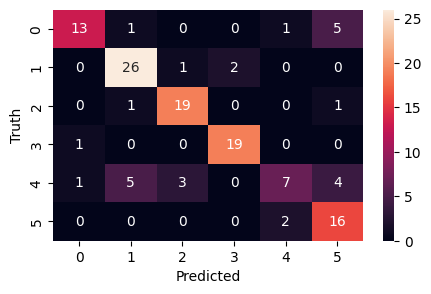

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_test, best_clf.predict(X_test))

plt.figure(figsize = (5,3))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [24]:
class_dict

{'David_Schwimmer': 0,
 'Jennifer_Aniston': 1,
 'Lisa_Kudrow': 2,
 'Courteney_Cox': 3,
 'Matt_LeBlanc': 4,
 'Matthew_Perry': 5}

## Save model

In [25]:
import pickle

filename = 'best_model.pkl'
pickle.dump(best_clf, open(filename, 'wb'))

In [26]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))